Name: Antony Krymski

Username: agk-123

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

plt.style.use("bmh")
plt.rcParams.update({'font.size': 10})

def scale(a):
    # minmax scaling 
    maxv = np.max(a, axis=0)
    minv = np.min(a, axis=0)
    return (a - minv) / (maxv - minv) * 2. - 1.

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(np.floor(len(X) * (1 - test_size)))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

def plot(x):
    plt.figure(figsize=(16, 2))
    plt.margins(x=0, y=0)
    plt.plot(x)
    plt.show()

def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(16, 2))
    ax.margins(x=0, y=0)
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_timeseries(**kwargs):
    fig, (ax) = plt.subplots(1, 1, sharex=True, figsize=(16, 2))
    ax.margins(x=0, y=0)
    index = kwargs['index'] if 'index' in kwargs else None
    for key, value in kwargs.items():
        if key == 'title':
            ax.set_title(value)
        elif key == 'index':
            pass
        else:
            if index is None:
                ax.plot(value, label=key)
            else:
                ax.plot(index, value, label=key)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_training(history, metric='loss'):
    plot_timeseries(index=range(history.params['epochs']), title=metric, train=history.history[metric], test=history.history['val_' + metric])

In [3]:
WINDOWS = 10
TIMESTEPS = 25
FEATURES = 1
CODE_SIZE = 32
BATCH_SIZE = 256

# Data

# Pre-processing

In [4]:
# Download our time series 
timeseries = download('^SPX')['Close']
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()
timeseries

Date
1970-01-05    0.004934
1970-01-06   -0.006871
1970-01-07   -0.002049
1970-01-08    0.000540
1970-01-09   -0.003026
                ...   
2024-08-20   -0.001987
2024-08-21    0.004231
2024-08-22   -0.008973
2024-08-23    0.011418
2024-08-26   -0.003159
Name: Close, Length: 13782, dtype: float64

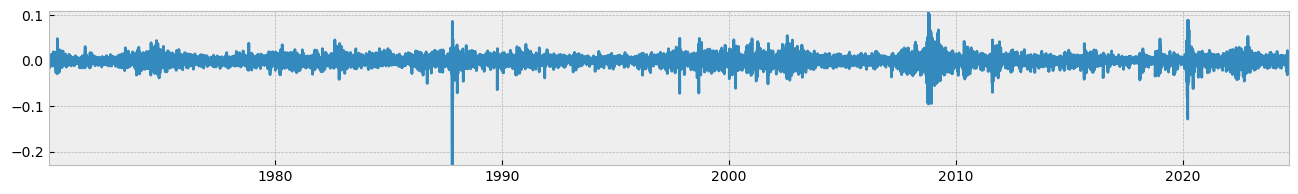

In [5]:
plot(timeseries)

Outliers 0.035878181362578504
(10825, 250) (2707, 250)
(10825,) (2707,)


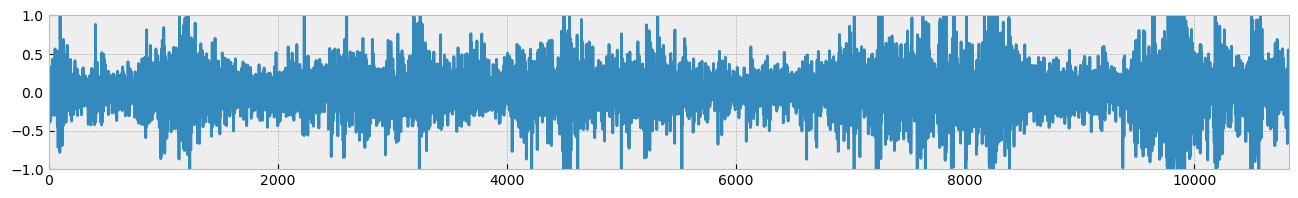

In [6]:
def load_data(w=None):
    X = timeseries.values

    # remove outliers
    outliers = np.quantile(np.abs(X), 0.99)
    X = np.clip(X, -outliers, outliers)
    print('Outliers', outliers)

    # scale
    X = X / outliers

    # generate lags
    X = window(X, w).astype(np.float32)
    y = timeseries[w:]
    return split(X, y, 0.2)

x_train, x_test, y_train, y_test = load_data(WINDOWS * TIMESTEPS)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_train).all() == True)

plot(x_train[:, 0])

In [7]:
evals = pd.DataFrame(index=['RMSE', 'MAE'])

def eval(name, y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    evals[name] = [ rmse, mae ]

In [8]:
# Base cases
eval('Persistence', y_test.shift(1).fillna(0), y_test)
eval('Zero', np.zeros(len(y_test)), y_test)
eval('Mean', np.full(len(y_test), np.mean(x_train[:, -1])), y_test)
evals

,Persistence,Zero,Mean
RMSE,0.016553,0.011006,0.013784
MAE,0.010519,0.007161,0.010394


In [9]:
# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
eval('LR', model.predict(x_test), y_test)

In [82]:
# # ARIMA
# import pmdarima as pm
# model = pm.auto_arima(x_train[:, -1], stationary=True, maxiter=5)
# eval('ARIMA', model.predict(len(x_test)), y_test)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=-11356.148, Time=12.87 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-11342.881, Time=2.94 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=-11353.629, Time=5.67 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=-11353.375, Time=4.93 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=-11336.794, Time=0.46 sec
 ARIMA(2,0,2)(0,0,1)[5] intercept   : AIC=-11354.117, Time=10.38 sec
 ARIMA(2,0,2)(1,0,0)[5] intercept   : AIC=-11354.550, Time=9.29 sec
 ARIMA(2,0,2)(2,0,1)[5] intercept   : AIC=-11354.743, Time=17.81 sec
 ARIMA(2,0,2)(1,0,2)[5] intercept   : AIC=-11355.670, Time=20.83 sec
 ARIMA(2,0,2)(0,0,0)[5] intercept   : AIC=-11344.058, Time=4.40 sec
 ARIMA(2,0,2)(0,0,2)[5] intercept   : AIC=-11355.722, Time=16.99 sec
 ARIMA(2,0,2)(2,0,0)[5] intercept   : AIC=-11356.084, Time=16.53 sec
 ARIMA(2,0,2)(2,0,2)[5] intercept   : AIC=-11350.332, Time=16.20 sec
 ARIMA(1,0,2)(1,0,1)[5] intercept   : AIC=inf, Time=8.89 sec
 ARIM

In [10]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((WINDOWS*TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



Epoch 1/15
43/43 [==============================] - 6s 99ms/step - loss: 2.0566e-04 - mae: 0.0098 - val_loss: 1.2252e-04 - val_mae: 0.0073
Epoch 2/15
43/43 [==============================] - 4s 84ms/step - loss: 1.3766e-04 - mae: 0.0083 - val_loss: 1.2333e-04 - val_mae: 0.0072
Epoch 3/15
43/43 [==============================] - 4s 89ms/step - loss: 1.3105e-04 - mae: 0.0080 - val_loss: 1.2471e-04 - val_mae: 0.0074
Epoch 4/15
43/43 [==============================] - 4s 86ms/step - loss: 1.2943e-04 - mae: 0.0079 - val_loss: 1.2342e-04 - val_mae: 0.0073
Epoch 5/15
43/43 [==============================] - 4s 86ms/step - loss: 1.2506e-04 - mae: 0.0078 - val_loss: 1.2499e-04 - val_mae: 0.0073
Epoch 6/15
43/43 [==============================] - 4s 84ms/step - loss: 1.2584e-04 - mae: 0.0077 - val_loss: 1.2471e-04 - val_mae: 0.0074
Epoch 7/15
43/43 [==============================] - 4s 91ms/step - loss: 1.2431e-04 - mae: 0.0077 - val_loss: 1.2223e-04 - val_mae: 0.0072
Epoch 8/15
43/43 [=========

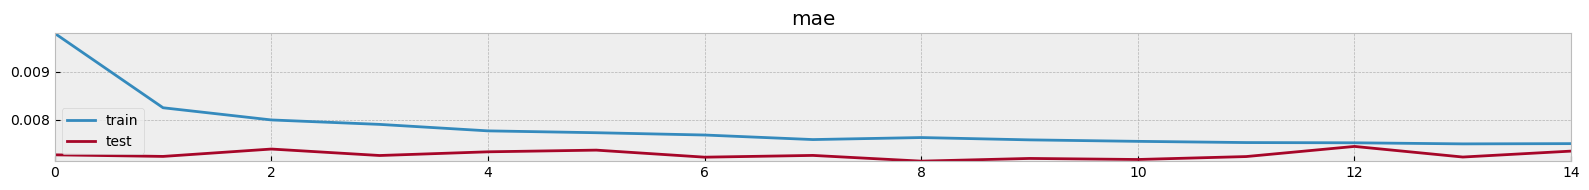

85/85 [==============================] - 1s 12ms/step


In [12]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((WINDOWS*TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=15, validation_data=(x_test, y_test))
plot_training(history, 'mae')

eval('LSTM', model.predict(x_test), y_test)

In [13]:
evals

,Persistence,Zero,Mean,LR,LSTM
RMSE,0.016553,0.011006,0.013784,0.011234,0.011098
MAE,0.010519,0.007161,0.010394,0.007349,0.007348


# Data Generation

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=TIMESTEPS, n_windows=WINDOWS):
        self.timesteps = timesteps
        self.n_windows = n_windows
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - (timesteps * n_windows) - timesteps)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        return self.data[idx:idx+self.timesteps, 0]
    
    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            windows = []
            for w in range(self.n_windows):
                window = self.get_window(idx + (w * self.timesteps))
                windows.append(window)

            y_positive = self.get_window(idx + (self.n_windows * self.timesteps))

            y_negative = self.get_window(idx + ((self.n_windows-1) * self.timesteps))
            y_negative = np.random.normal(np.mean(y_negative), np.std(y_negative), len(y_negative))

            # positive sample
            x.append(windows)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(windows)
            y.append(y_negative)
            labels.append(0)
        
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.float32)
        labels = np.array(labels).astype(np.float32)

        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        
        return (x, y), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

Batches: 41
x shape: (256, 10, 25, 1), y shape: (256, 25, 1), labels shape: (256,)


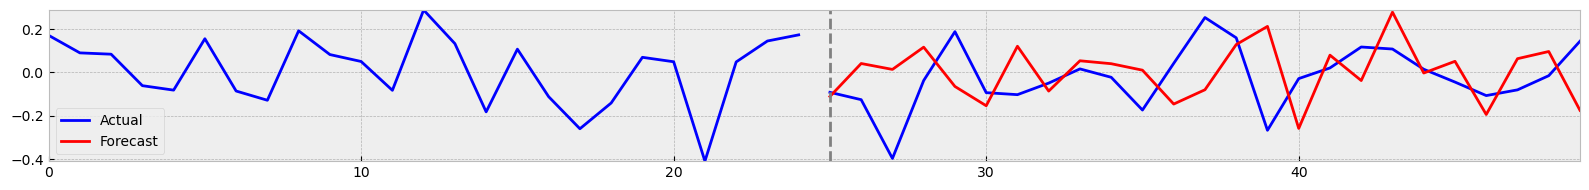

In [15]:
# Test generator
dg = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
print('Batches:', len(dg))

# Get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

plot_forecast(bx[0, -1, :, 0], by[0, :, 0], by[1, :, 0])

# CPC Model Architecture

In [34]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(input)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = Flatten()(x)
    # x = Dropout(0.5)(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((TIMESTEPS, FEATURES), CODE_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 64)            256       
                                                                 
 conv1d_3 (Conv1D)           (None, 25, 64)            12352     
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                51232     
                                                                 
Total params: 63,840
Trainable params: 63,840
Non-trainable params: 0
_________________________________________________________________


In [35]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    # x = LSTM(128, return_sequences=True, name="context")(input)
    x = LSTM(64, return_sequences=False, name="context")(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((WINDOWS, CODE_SIZE), CODE_SIZE)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10, 32)]          0         
                                                                 
 context (LSTM)              (None, 64)                24832     
                                                                 
 preds (Dense)               (None, 32)                2080      
                                                                 
Total params: 26,912
Trainable params: 26,912
Non-trainable params: 0
_________________________________________________________________


In [36]:
x_input = Input((WINDOWS, TIMESTEPS, FEATURES))
x_encoded = TimeDistributed(encoder)(x_input)

y_pred = context(x_encoded)

y_input = Input((TIMESTEPS, FEATURES))
y_encoded = encoder(y_input)

output = K.mean(y_encoded * y_pred, axis=-1)
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 10, 25, 1)]  0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 25, 1)]      0           []                               
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 10, 32)      63840       ['input_10[0][0]']               
 buted)                                                                                           
                                                                                                  
 encoder (Functional)           (None, 32)           63840       ['input_11[0][0]']             

In [37]:
train_gen = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=BATCH_SIZE, shuffle=True)

In [39]:
history = model.fit(train_gen, epochs=20, validation_data=test_gen)

Epoch 1/20
41/41 [==============================] - 1s 29ms/step - loss: 0.4678 - binary_accuracy: 0.7756 - val_loss: 0.5217 - val_binary_accuracy: 0.7344
Epoch 2/20
41/41 [==============================] - 1s 29ms/step - loss: 0.4713 - binary_accuracy: 0.7728 - val_loss: 0.5282 - val_binary_accuracy: 0.7257
Epoch 3/20
41/41 [==============================] - 1s 25ms/step - loss: 0.4665 - binary_accuracy: 0.7764 - val_loss: 0.5148 - val_binary_accuracy: 0.7370
Epoch 4/20
41/41 [==============================] - 1s 25ms/step - loss: 0.4731 - binary_accuracy: 0.7732 - val_loss: 0.5092 - val_binary_accuracy: 0.7474
Epoch 5/20
41/41 [==============================] - 1s 25ms/step - loss: 0.4589 - binary_accuracy: 0.7745 - val_loss: 0.5296 - val_binary_accuracy: 0.7374
Epoch 6/20
41/41 [==============================] - 1s 26ms/step - loss: 0.4555 - binary_accuracy: 0.7815 - val_loss: 0.5200 - val_binary_accuracy: 0.7431
Epoch 7/20
41/41 [==============================] - 1s 25ms/step - los

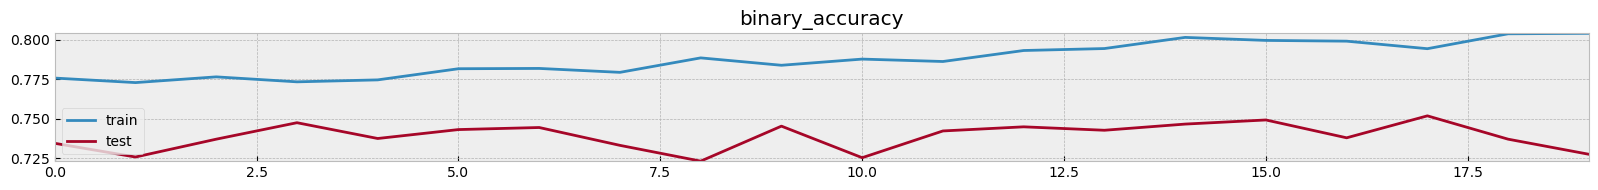

In [40]:
plot_training(history, 'binary_accuracy')

In [41]:
encoder.save('encoder.h5')

# Downstream Task

In [42]:
encoder = load_model('encoder.h5', compile=True)

In [43]:
x_train, x_test, y_train, y_test = load_data(TIMESTEPS)
x_train.shape

Outliers 0.035878181362578504


(11005, 25)

In [44]:
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)

86/86 [==============================] - 0s 1ms/step


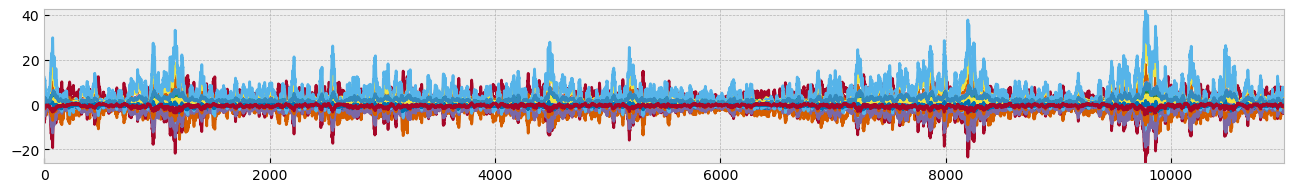

In [45]:
plot(x_train_embeds)

In [46]:
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)

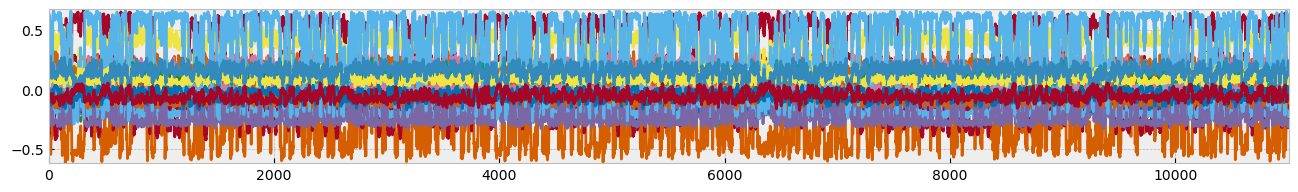

In [47]:
plot(x_train_embeds)

/Users/antonykrymski/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


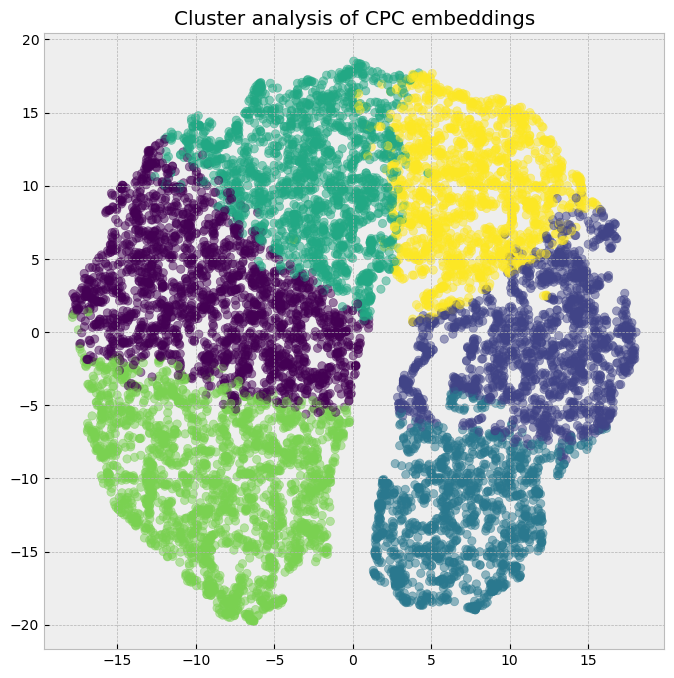

In [49]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=350)
embeddings_tsne = tsne.fit_transform(x_train_embeds)

# Apply K-means clustering
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(x_train_embeds)

# Visualize the clusters using the t-SNE embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Cluster analysis of CPC embeddings')
plt.show()

In [50]:
# Linear Regression with CPC embeddings
model = LinearRegression()
model.fit(x_train_embeds, y_train)
eval('CPC-LR', model.predict(x_test_embeds), y_test)
evals

,Persistence,Zero,Mean,LR,LSTM,CPC-LR
RMSE,0.016553,0.011006,0.013784,0.011234,0.011098,0.010976
MAE,0.010519,0.007161,0.010394,0.007349,0.007348,0.007159


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable p

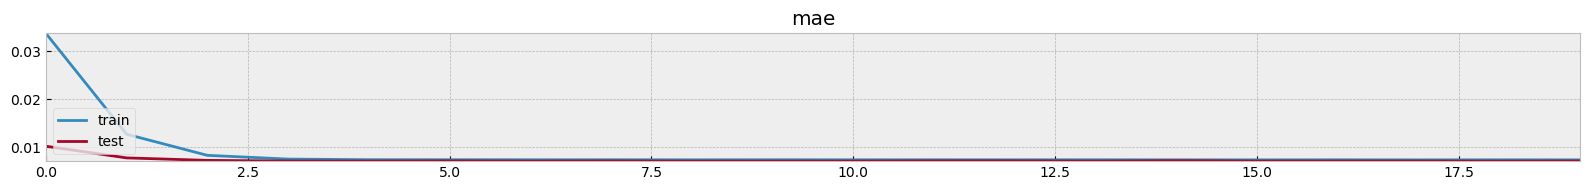

86/86 [==============================] - 0s 1ms/step


In [52]:
def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='linear')(x)
    return Model(input, x)

model = build_dense(CODE_SIZE)
model.compile(loss='mse', metrics=['mae'])
model.summary()

history = model.fit(x_train_embeds, y_train, batch_size=BATCH_SIZE, epochs=20, validation_data=(x_test_embeds, y_test))
plot_training(history, 'mae')

eval('CPC', model.predict(x_test_embeds), y_test)

In [53]:
evals

,Persistence,Zero,Mean,LR,LSTM,CPC-LR,CPC
RMSE,0.016553,0.011006,0.013784,0.011234,0.011098,0.010976,0.010958
MAE,0.010519,0.007161,0.010394,0.007349,0.007348,0.007159,0.007136


# Optimize Sharpe

In [123]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_63 (Dense)            (None, 64)                2112      
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                                                                 
 dense_64 (Dense)            (None, 64)                4160      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable 

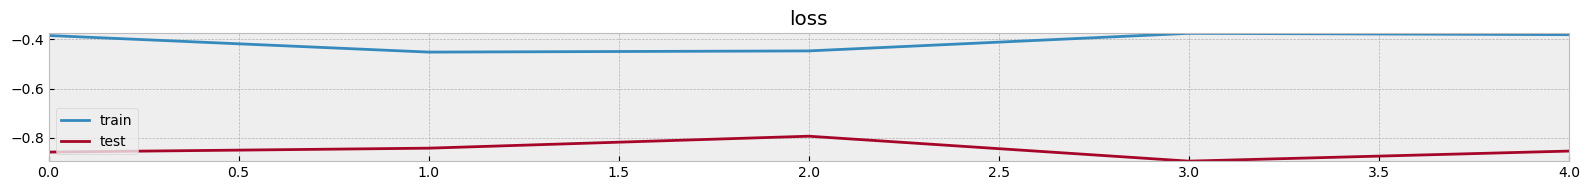

In [124]:
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

def sharpe_loss(log_returns, allocations):
    portfolio_returns = log_returns[1:, 0] * allocations[:-1, 0]
    # Negative Sharpe ratio (to maximize it)
    return -sharpe_ratio(portfolio_returns)

def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(input, x)

model = build_dense((CODE_SIZE))
model.compile(loss=sharpe_loss, optimizer='adam')
model.summary()

history = model.fit(x_train_embeds, train_returns, batch_size=252, epochs=5, validation_data=(x_test_embeds, test_returns))
plot_training(history, 'loss')


In [131]:
allocations = model.predict(x_test_embeds)[:, 0]*1.5
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

86/86 [==============================] - 0s 1ms/step
Strategy Sharpe 0.6428133403571584
Benchmark Sharpe 0.6300655969368948


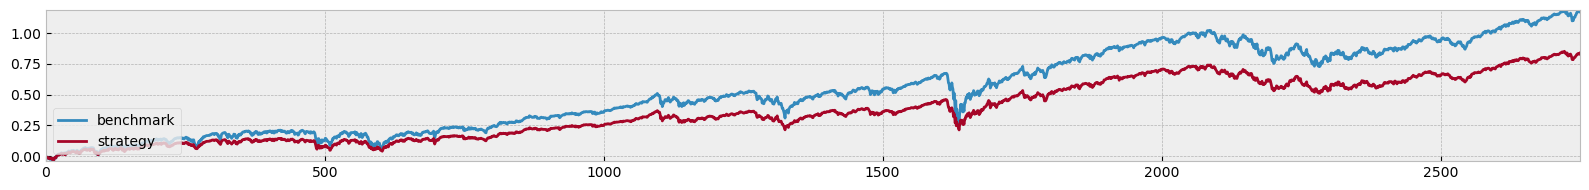

In [132]:
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

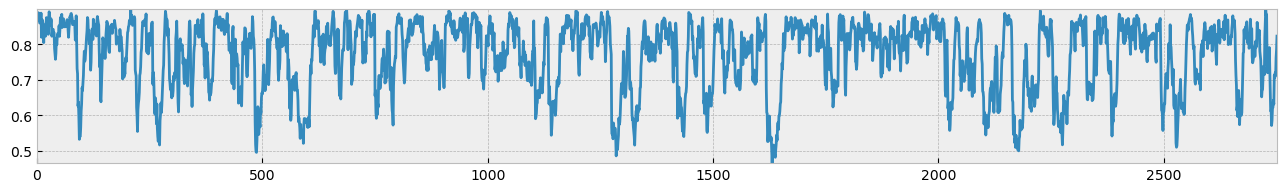

In [133]:
plot(allocations)